# Coin search by t-SNE via Tensorflow
- https://github.com/despoisj/CoinsDataset
- https://github.com/kylemcdonald/Parametric-t-SNE
- https://github.com/gokceneraslan/tensorsne
- https://github.com/zaburo-ch/Parametric-t-SNE-in-Keras/blob/master/mlp_param_tsne.py
- https://github.com/danielfrg/tsne

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.examples.tutorials.mnist import input_data
from IPython.display import clear_output
import pandas as pd
from scipy import spatial
from collections import defaultdict
import os
import cv2
import itertools

%run datasets.ipynb
%run visualisation.ipynb
%run tsne.ipynb

%matplotlib inline

## Load data

In [3]:
def load_stamps_dataset(ndata):
    return load_image_dataset(
        img_shape = [64, 64, 1],
        path      = "/netforge/datasets/common/document_parts/10000/stamp",
        ndata     = ndata)

def load_coins_dataset(ndata):
    return load_image_dataset(
        img_shape = [64, 64, 1],
        path      = "/netforge/datasets/private/roman/coins/images",
        ndata     = ndata)

In [4]:
data_size = 30000
(
    image_shape, 
    file_num,
    train_images, 
    train_labels, 
    test_images, 
    test_labels
) = load_mnist_dataset(data_size)

print("File num   :", file_num)
print("Data size  :", data_size)
print("Train shape:", list(train_images.shape))
print("Test  shape:", list(test_images.shape))
print("Image shape:", image_shape)

Extracting /tmp/MNIST_data/train-images-idx3-ubyte.gz
Extracting /tmp/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /tmp/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/MNIST_data/t10k-labels-idx1-ubyte.gz
File num   : 65000
Data size  : 30000
Train shape: [30000, 784]
Test  shape: [10000, 784]
Image shape: [28, 28, 1]


## Visualisation

Train images:


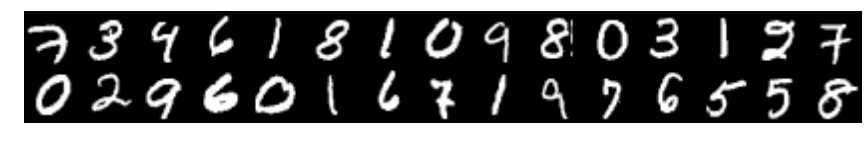

Test images:


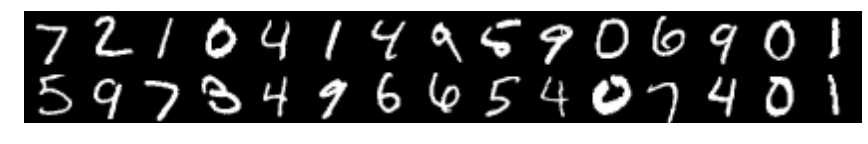

In [5]:
print("Train images:")
show_images(train_images, image_shape, rows=2, cols=15)
print("Test images:")
show_images(test_images, image_shape, rows=2, cols=15)

## Prepare TSNE data

In [ ]:
%%time

# TODO: USE BATCH SIZE! instead of data_size

joint_probs = compute_joint_probabilities(train_images, batch_size=data_size, verbose=2)

Precomputing P-values...
Computing pairwise distances...
Computing P-values...
Computed P-values 0 of 30000 datapoints...
Computed P-values 500 of 30000 datapoints...


## TF Neural Networks

In [13]:
def conv2d_maxpool(inputs, filters, kernel_size=[3,3], padding="same", activation=tf.nn.relu):
    l = tf.layers.conv2d(
        inputs=inputs,
        filters=filters,
        kernel_size=kernel_size,
        padding=padding,
        activation=tf.nn.relu)
    return tf.layers.max_pooling2d(l, pool_size=[2, 2], strides=2)

def Perceptron(inputs, out_dim):
    l = inputs
    l = tf.contrib.layers.flatten(l)
    l = tf.layers.dense(l, units=100, activation=tf.nn.relu)
    l = tf.layers.dense(l, units=200, activation=tf.nn.relu)
    l = tf.layers.dense(l, units=100, activation=tf.nn.relu)
    l = tf.layers.dense(l, units=out_dim)
    return l

def ConvNet(inputs, out_dim):
    l = conv2d_maxpool(l, 16)
    l = conv2d_maxpool(l, 32)
    l = conv2d_maxpool(l, 64)
    l = conv2d_maxpool(l, 128)
    l = tf.contrib.layers.flatten(l)
    l = tf.layers.dense(l, units=300, activation=tf.nn.relu)
    l = tf.layers.dense(l, units=out_dim)
    return l

### Embedding Graph

In [15]:
learning_rate = 1e-4
embed_dims    = 9
tf.reset_default_graph()
em_graph = tf.Graph()
with em_graph.as_default():
    with tf.name_scope('embedding'):
        with tf.device('/gpu:0'):
            images_pl  = tf.placeholder(dtype=tf.float32, shape=[None,]+image_shape)
            probs_pl   = tf.placeholder(dtype=tf.float32, shape=joint_probs.shape)
            probs_var  = tf.Variable(probs_pl, trainable=False)
            embed_op   = Perceptron(images_pl, embed_dims)    
            embed_loss = tsne_loss(probs_var, data_size, embed_dims, embed_op)
            train_op   = tf.train.AdamOptimizer(learning_rate).minimize(embed_loss)
            init_op    =tf.global_variables_initializer()

### Train embedding

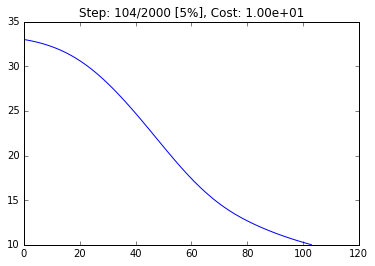

CPU times: user 30.6 s, sys: 25.9 s, total: 56.5 s
Wall time: 26.5 s


In [16]:
%%time

train_steps = 2000
log_every   = 1

try:
    sess.close()
    print("Session closed")
except:
    pass

sess = tf.Session(graph=em_graph)
sess.run(init_op, feed_dict={probs_pl:joint_probs})

def plot_costs(costs, step, step_num):
    plt.plot(costs)
    plt.title("Step: %d/%d [%.0f%%], Cost: %.2e" % (
        step+1, step_num, 100*(step+1)/step_num, costs[-1]))
    clear_output(True)
    plt.show()

def get_next_batch(i, bs):
    imgs = train_images[i:i+bs]
    imgs = np.reshape(imgs, [-1,]+image_shape)
    lbls = train_labels[i:i+bs]
    i = (i + bs) % (len(train_images))
    return i, imgs, lbls

def do_train(sess, tr_op, loss_op, inputs_pl, batch_sise, step_num):
    try:
        costs = []
        bi = 0
        for step in range(step_num):
            bi, images, _ = get_next_batch(bi, batch_sise)
            _, cost = sess.run([tr_op, loss_op], feed_dict={inputs_pl: images})
            costs.append(cost)
            if step % log_every == log_every-1:
                plot_costs(costs, step, step_num)
    except KeyboardInterrupt:
        pass
    plot_costs(costs, step, step_num)
    
do_train(sess, train_op, embed_loss, images_pl, data_size, train_steps)

### Find nearest

Data size: 1000 x 9


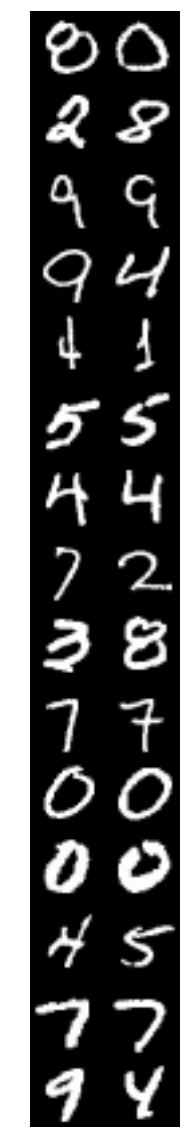

CPU times: user 1.08 s, sys: 136 ms, total: 1.22 s
Wall time: 1.05 s


In [17]:
%%time

def embed_database(imgs):
    imgs = np.reshape(imgs, [-1,]+image_shape)
    embeds = sess.run(embed_op, feed_dict = {images_pl : imgs})
    return imgs, embeds

def embed_targets(ds, num):
    idx = list(range(len(ds)))
    np.random.shuffle(idx)
    imgs = ds[idx]
    imgs = np.reshape(imgs, [-1,]+image_shape)
    embeds = sess.run(embed_op, feed_dict = {images_pl : imgs})
    return imgs[:num], embeds[:num]

def find_nearest(targets, candidates):
    tree = spatial.KDTree(candidates)
    results = tree.query(targets)
    return results[1], results[0] 

def test_find_nearest_images(database, targets, num):
    trg_img, trg_emb = embed_targets(targets, num)
    dat_img, dat_emb = embed_database(database)

    nearests, distances = find_nearest(trg_emb, dat_emb)
    res_img = dat_img[nearests]

    print("Data size:", data_size, "x", embed_dims)
    
    img_1 = trg_img.reshape([num*image_shape[0],image_shape[1]])
    img_2 = res_img.reshape([num*image_shape[0],image_shape[1]])
    sheet = np.concatenate([img_1, img_2], axis=1)
    plt.figure(figsize = (60,20))
    plt.axis("off")
    plt.imshow(sheet, cmap='gray');
    plt.show()
        
test_find_nearest_images(
    database  = test_images, 
    targets   = train_images, 
    num=15)

### EOF